In [381]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [424]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [425]:
X = train.drop(["PassengerId", "Ticket", "Survived"], axis=1)
X_test = test.drop(["PassengerId", "Ticket"], axis=1)
y = train.Survived

In [426]:
# Data preprocessing
data = [X, X_test]
enc = OrdinalEncoder()
for dataset in data:    
    # Getting type of cabin from cabin number
    dataset['Cabin'] = dataset['Cabin'].fillna(0)
    dataset['Cabin'] = [str(i)[0] for i in dataset['Cabin']]
    
    # Filling NA in column Embarked with the most common value
    common = dataset['Embarked'].describe().top
    dataset['Embarked'] = dataset['Embarked'].fillna(common)
    
    # Filling NA in Age with mean
    mean_age = dataset['Age'].mean()
    dataset['Age'] = dataset['Age'].fillna(mean_age)
    
    # Taking title from name
    dataset['Name'] = [i.split('.')[0].split(',')[-1] for i in dataset['Name']]
    dataset['Name'] = dataset['Name'].replace(['Lady', 'the Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare', regex=True)
    dataset['Name'] = dataset['Name'].replace('Mlle', 'Miss', regex=True)
    dataset['Name'] = dataset['Name'].replace('Ms', 'Miss', regex=True)
    dataset['Name'] = dataset['Name'].replace('Mme', 'Mrs', regex=True)
    
    # Converting object columns to numeric
    s = (dataset.dtypes == 'object')
    object_cols = list(s[s].index)
    dataset[object_cols] = enc.fit_transform(dataset[object_cols]).astype(int)
    
    dataset.rename(columns={'Name': 'Title', 'Cabin': 'Cabin_type'}, inplace=True)
    
    # Creating age groups
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[dataset['Age'] > 66, 'Age'] = 6
    
    # Converting Fare to integer
    dataset['Fare'] = dataset['Fare'].fillna(0).astype(int)

In [427]:
def get_mae_score(clf, X_train, X_valid, y_train, y_valid):
    clf.fit(X_train, y_train)
    return mean_absolute_error(clf.predict(X_valid), y_valid)

In [428]:
def get_roc_auc_score(clf, X_train, X_valid, y_train, y_valid):
    clf.fit(X_train, y_train)
    return roc_auc_score(y_valid, clf.predict(X_valid))

In [429]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [430]:
temp_clf = RandomForestClassifier(random_state = 0)
scores = cross_val_score(temp_clf, X_train, y_train, cv=10, scoring='accuracy')

In [431]:
print(scores.mean())
print(scores.std())
print(get_mae_score(temp_clf, X_train, X_valid, y_train, y_valid))
print(get_roc_auc_score(temp_clf, X_train, X_valid, y_train, y_valid))

0.8216940532081377
0.05491857284132563
0.15083798882681565
0.8435006435006436


In [432]:
temp_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [433]:
importances = pd.DataFrame({'Name': clf.feature_names_in_, 'Importance': clf.feature_importances_})\
.sort_values('Importance', ascending=False)

<Axes: >

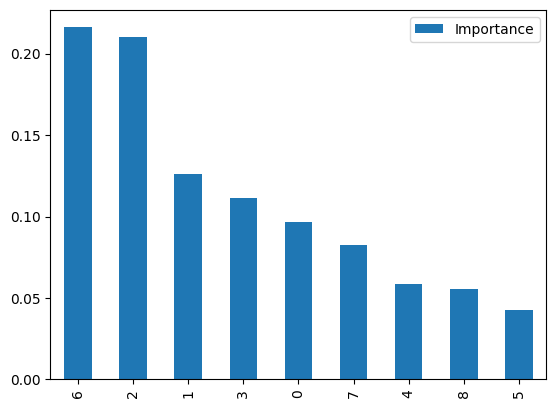

In [434]:
importances.plot.bar()

In [435]:
params_grid = { "criterion" : ["gini", "entropy"],
               "min_samples_leaf" : [1, 5, 10, 25, 50, 70],
               "min_samples_split" : [2, 4, 10, 12, 16, 18, 25, 35],
               "n_estimators": [100, 400, 700, 1000, 1500]}

In [436]:
search_clf = RandomForestClassifier()
search = GridSearchCV(search_clf, params_grid)

In [437]:
#{'criterion': 'gini',
# 'min_samples_leaf': 1,
# 'min_samples_split': 10,
# 'n_estimators': 100}

best_clf = RandomForestClassifier(criterion='gini', min_samples_leaf=1, min_samples_split=10, n_estimators=100)

In [438]:
best_clf.fit(X, y)

RandomForestClassifier(min_samples_split=10)

In [439]:
gender_submission = pd.DataFrame({"PassengerId": test.PassengerId, "Survived": best_clf.predict(X_test)})

In [440]:
gender_submission.to_csv('gender_submission.csv', index=False)